In [33]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
dataset = load_data()

In [37]:
type(dataset)

tuple

In [0]:
(X_train, y_train), (X_test, y_test) = dataset
# X_train.shape             (60000, 28, 28)
# y_train.shape             (60000,)
# X_test.shape              (10000, 28, 28)
# y_test.shape              (10000,)

In [0]:
# It is also recommended that real images used to train the discriminator are scaled so that their pixel values 
# are in the range [-1,1]. This is so that the discriminator will always receive images as input, real and fake, 
# that have pixel values in the same range.
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

In [0]:
# Flatten the data
H, W = X_train.shape[1:]               # (28, 28)
D = H * W                              # 784
X_train = X_train.reshape(-1, D)       # (60000, 784)
X_test = X_test.reshape(-1, D)         # (10000, 784)

In [0]:
# Dimensionality of the latent space
DIM = 100

In [0]:
batch_size = 32

steps_per_epoch = X_train.shape[0] // batch_size         # 60000 // 32
# print(steps_per_epoch)                                 # 1875

ones = np.ones(batch_size)                               # (32,)
zeros = np.zeros(batch_size)                             # (32,)

In [43]:
# Generator will take the input from latent space which is of the size 100 and output an image of size 784. This will be fed into a Discriminator.
def make_generator_model(noise):
  i = Input(shape=(noise))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization()(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization()(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

generator = make_generator_model(DIM)
generator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               25856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_8 (Batch (None, 1024)              4096

In [44]:
# Discriminator will take the input from real data which is of the size 784 and also the images of size 784 generated from Generator.
def make_discriminator_model(D):
  i = Input(shape=(D))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

discriminator = make_discriminator_model(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [45]:
# We now create the GAN where we combine the Generator and Discriminator. 
# When we train the Generator we will freeze the Discriminator.
# We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

# Create an input to represent noise sample from latent space
gan_input = Input(shape=(DIM,))
# Pass noise through generator to get an image
image = generator(gan_input)
# Make sure only the generator is trained
discriminator.trainable = False
# Pass this image through discriminator to get a fake image
fake_image = discriminator(image)
# Create the combined model object
gan = Model(gan_input, fake_image)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_6 (Model)              (None, 784)               1493520   
_________________________________________________________________
model_7 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [0]:
# # A function to generate a grid of random samples from the generator
# # and save them to a file
# def sample_images(epoch):
#   rows, cols = 5, 5
#   noise = np.random.randn(rows * cols, latent_dim)
#   imgs = generator.predict(noise)

#   # Rescale images 0 - 1
#   imgs = 0.5 * imgs + 0.5

#   fig, axs = plt.subplots(rows, cols)
#   idx = 0
#   for i in range(rows):
#     for j in range(cols):
#       axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
#       axs[i,j].axis('off')
#       idx += 1
#   fig.savefig("gan_images/%d.png" % epoch)
#   plt.close()

def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

epoch: 1/10000, d_loss: 0.66, d_acc: 0.69, g_loss: 0.87
epoch: 101/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.66
epoch: 201/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 4.90
epoch: 301/10000, d_loss: 0.08, d_acc: 0.97, g_loss: 1.54
epoch: 401/10000, d_loss: 0.03, d_acc: 1.00, g_loss: 3.17
epoch: 501/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 2.74
epoch: 601/10000, d_loss: 1.04, d_acc: 0.62, g_loss: 1.35
epoch: 701/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 3.64
epoch: 801/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.71
epoch: 901/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 9.95
epoch: 1001/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.80
epoch: 1101/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 5.70
epoch: 1201/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 2.22
epoch: 1301/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.39
epoch: 1401/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.88
epoch: 1501/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 6.40
epoch: 1601/10000, d_loss: 0.00, d_acc: 1.00, g_loss: 6.59
epoch: 17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


epoch: 4101/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 3.06
epoch: 4201/10000, d_loss: 0.00, d_acc: 1.00, g_loss: 7.23
epoch: 4301/10000, d_loss: 0.04, d_acc: 0.98, g_loss: 4.89
epoch: 4401/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 3.08
epoch: 4501/10000, d_loss: 0.03, d_acc: 0.98, g_loss: 6.86
epoch: 4601/10000, d_loss: 0.03, d_acc: 0.98, g_loss: 4.14
epoch: 4701/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 2.91
epoch: 4801/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 2.67
epoch: 4901/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 2.35
epoch: 5001/10000, d_loss: 0.02, d_acc: 1.00, g_loss: 4.38
epoch: 5101/10000, d_loss: 0.04, d_acc: 1.00, g_loss: 4.76
epoch: 5201/10000, d_loss: 0.00, d_acc: 1.00, g_loss: 2.66
epoch: 5301/10000, d_loss: 0.07, d_acc: 0.98, g_loss: 5.06
epoch: 5401/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 4.62
epoch: 5501/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 1.87
epoch: 5601/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 2.43
epoch: 5701/10000, d_loss: 0.01, d_acc: 1.00, g_loss: 5.

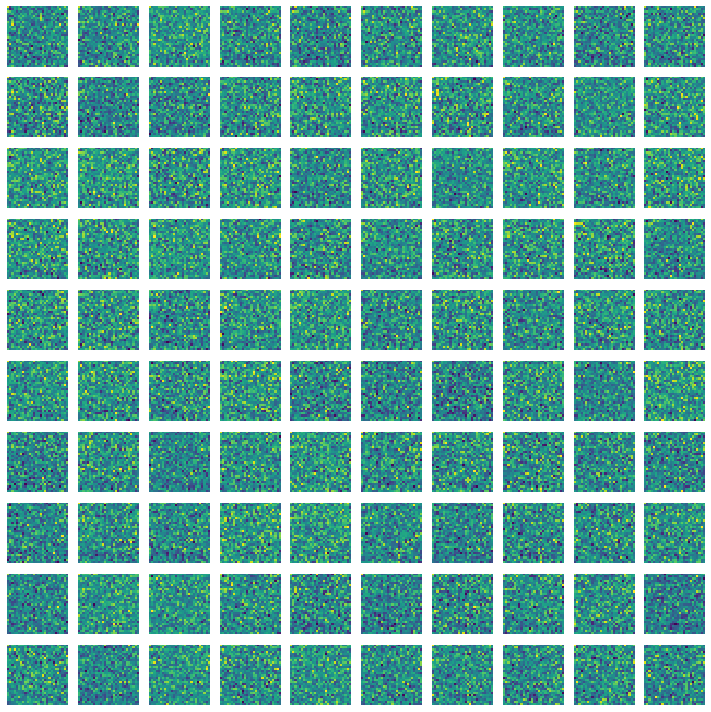

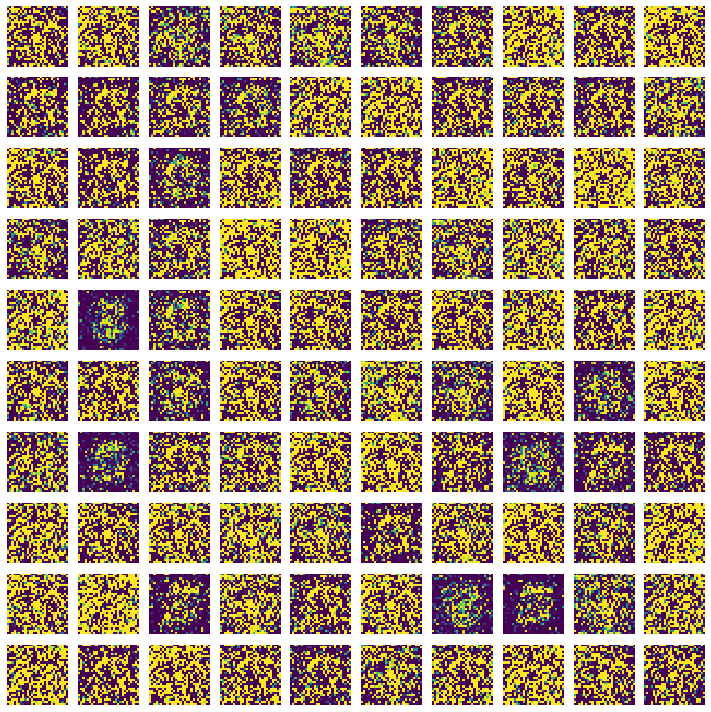

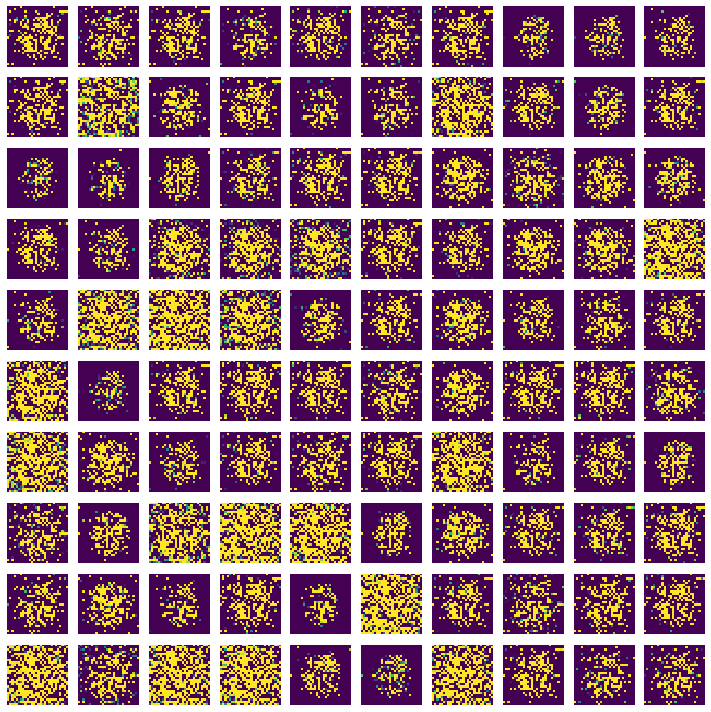

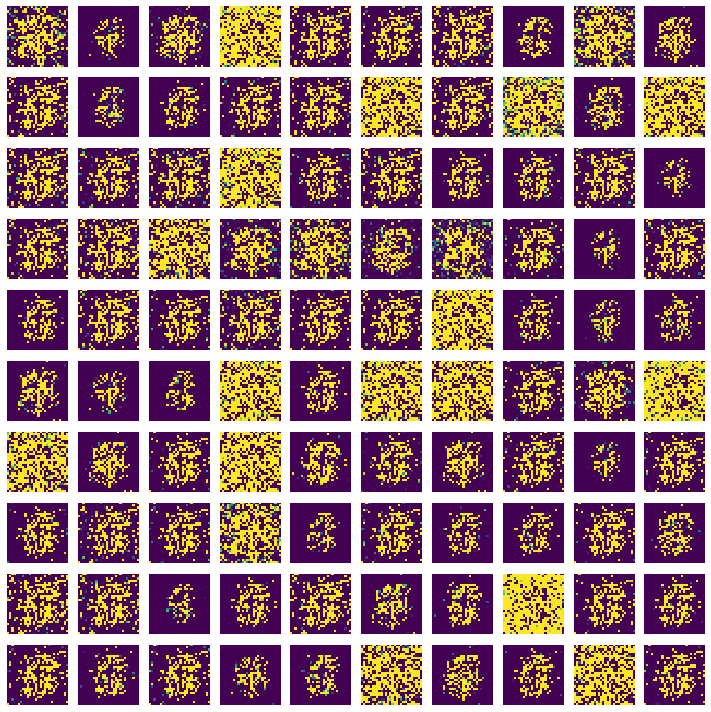

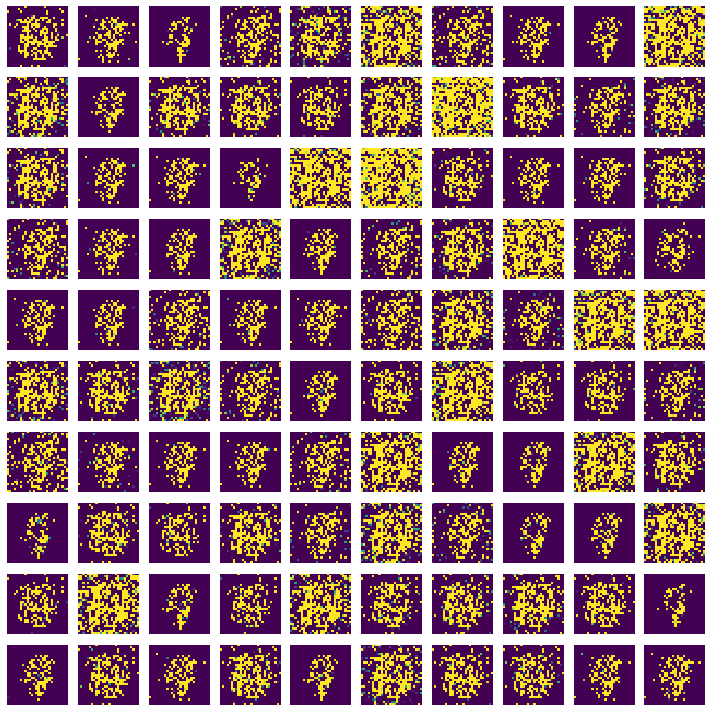

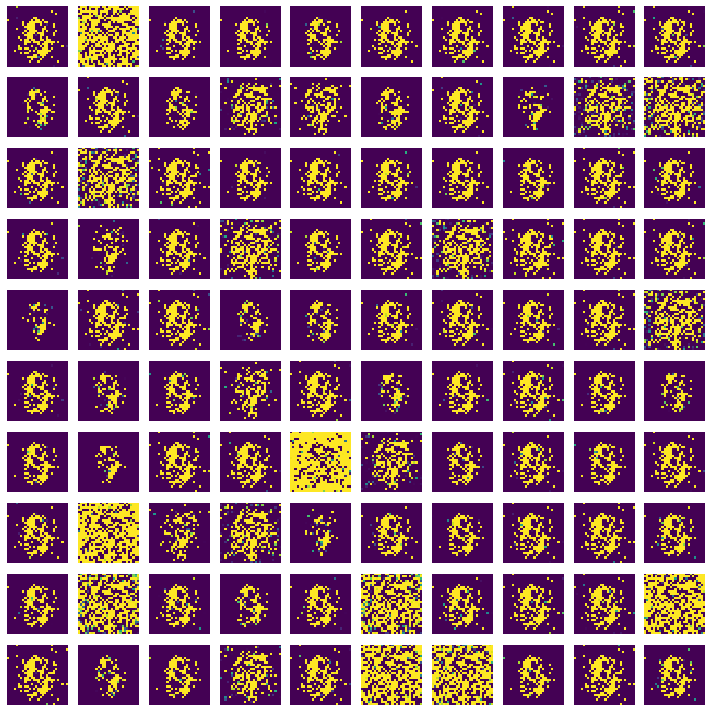

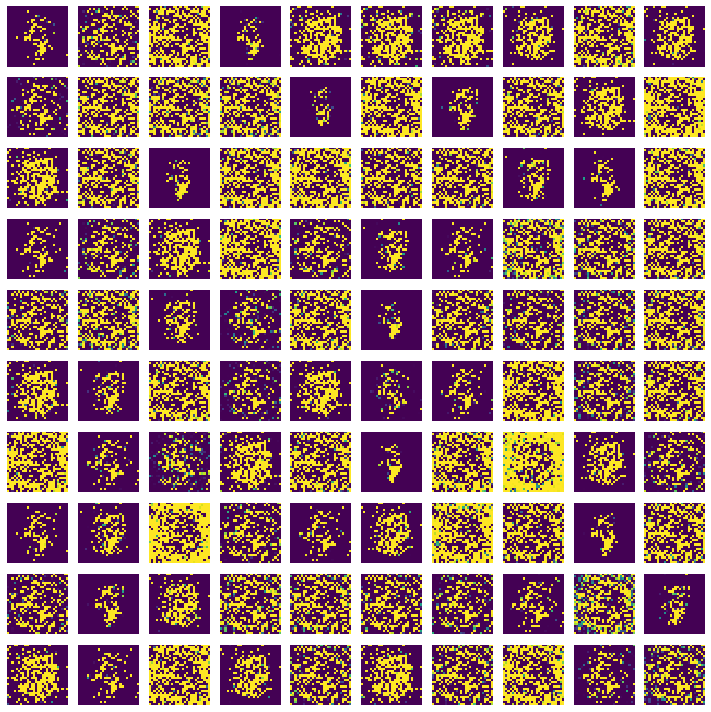

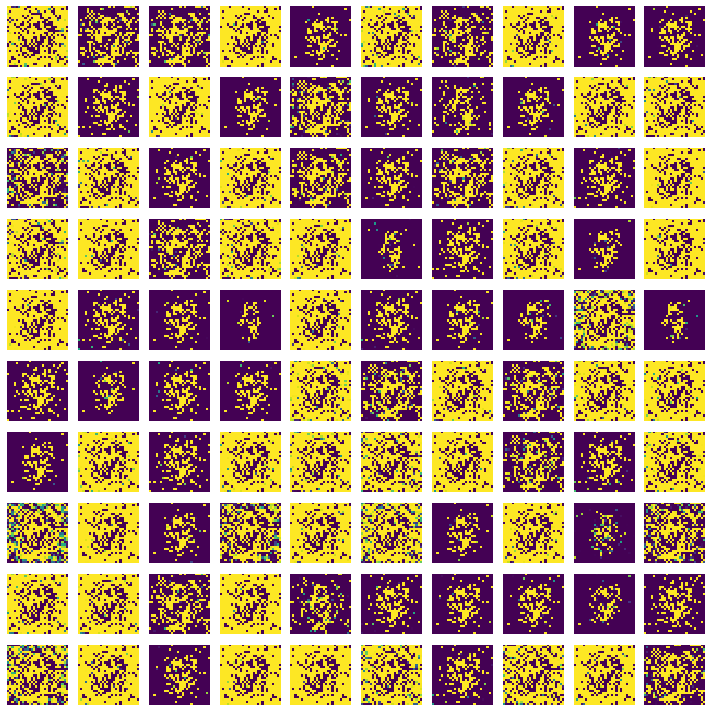

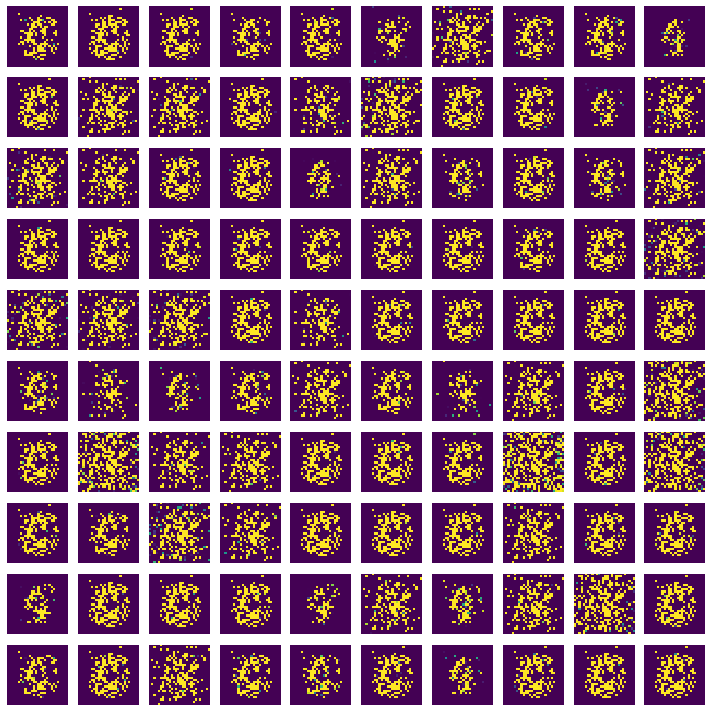

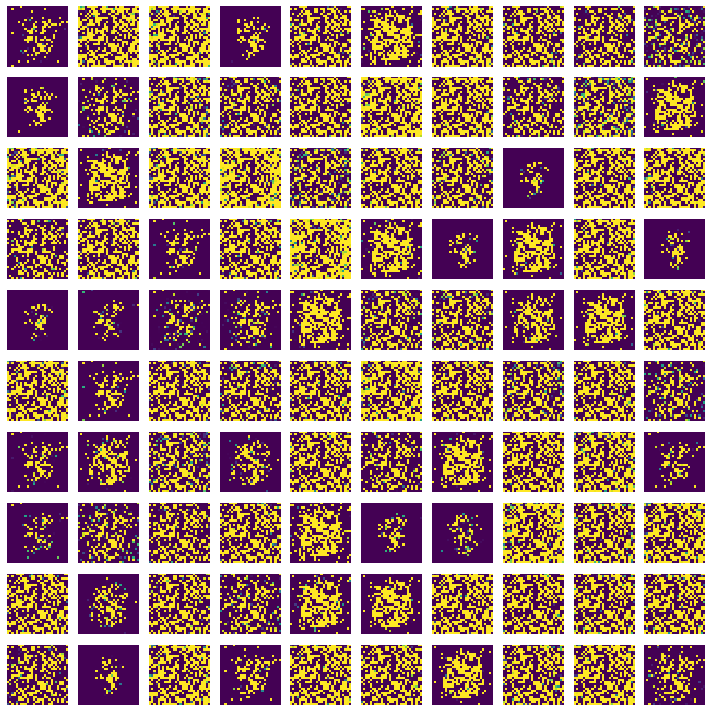

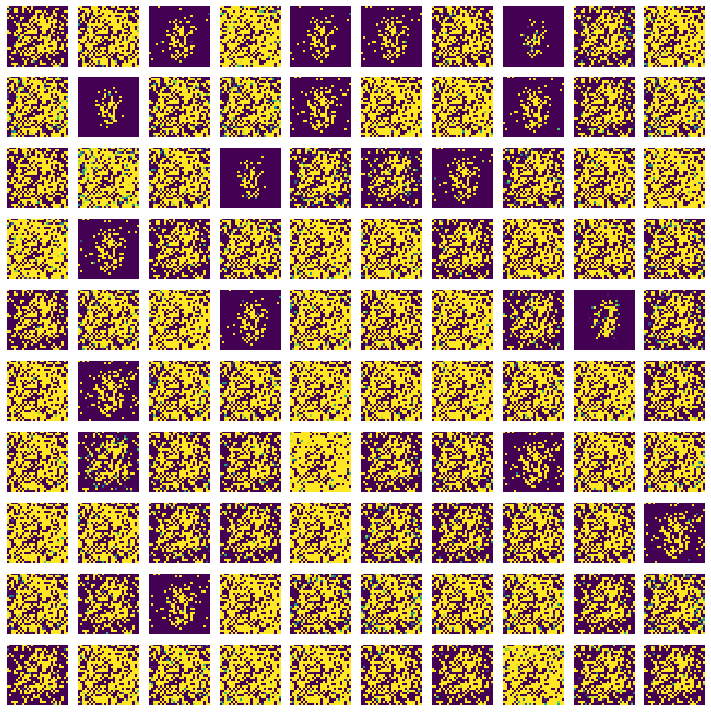

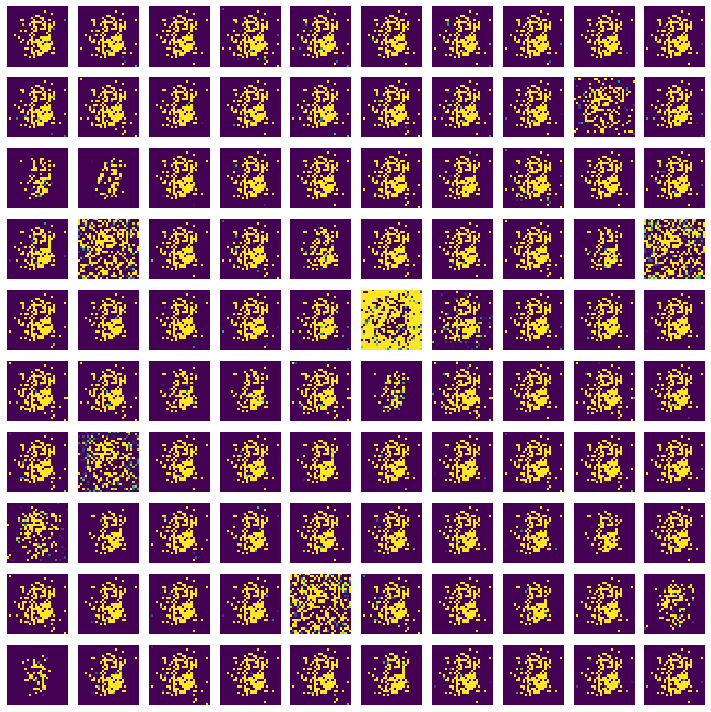

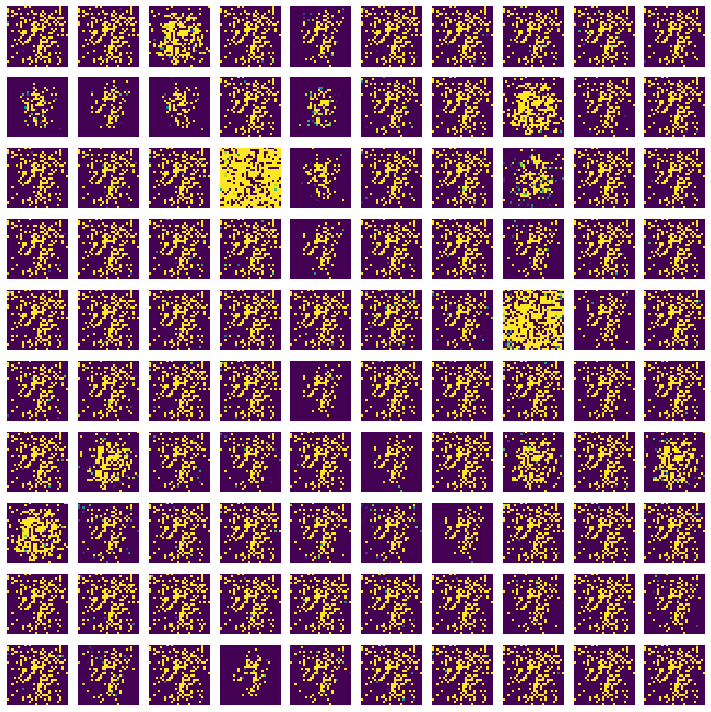

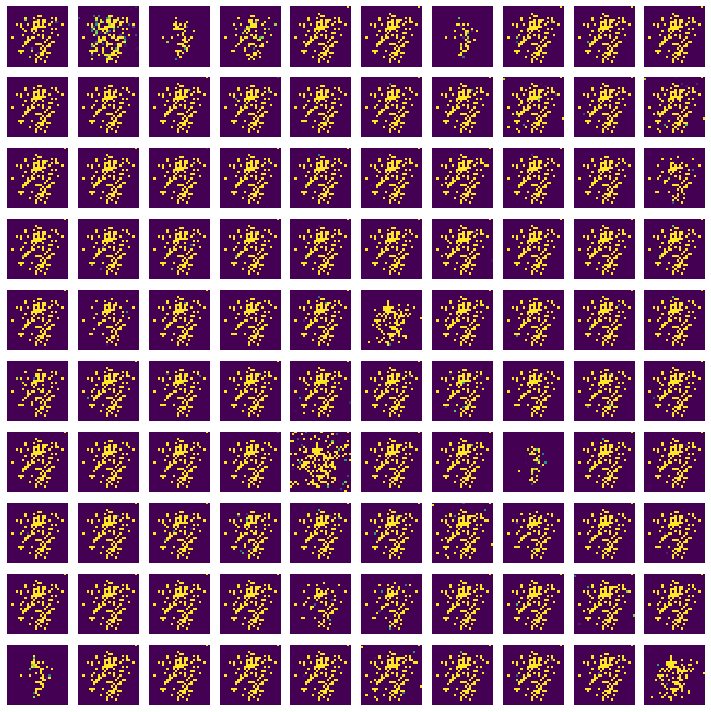

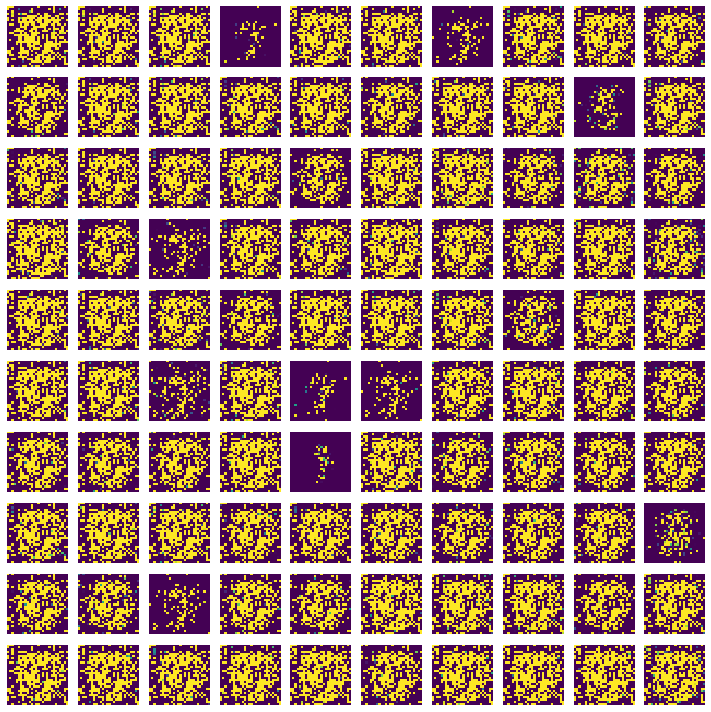

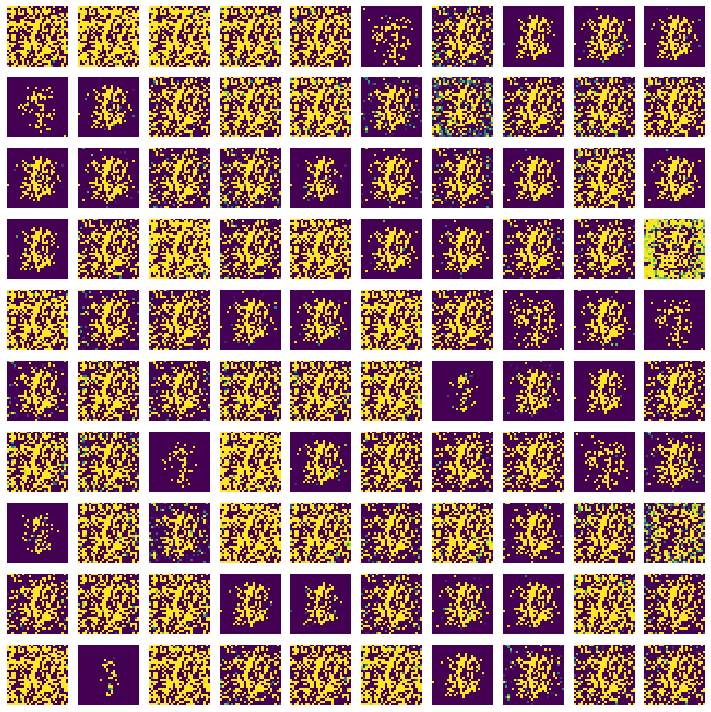

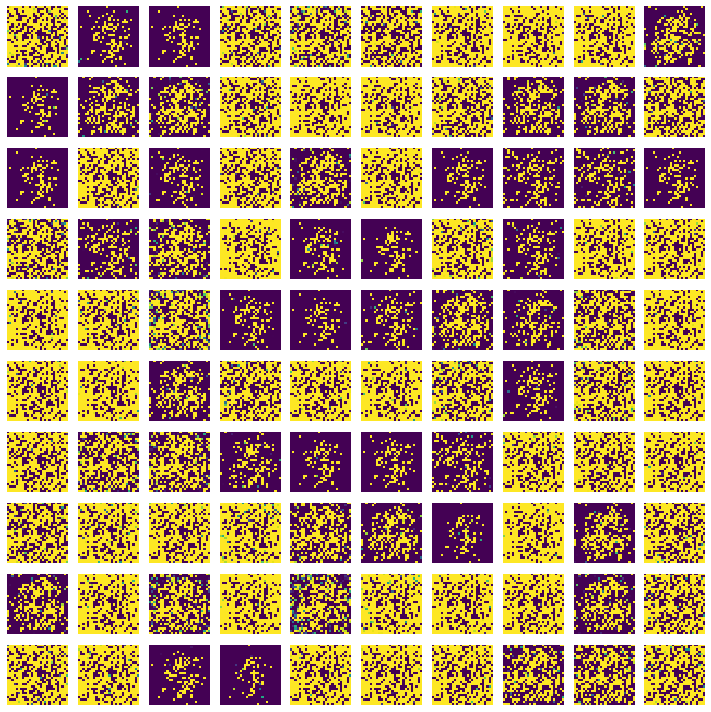

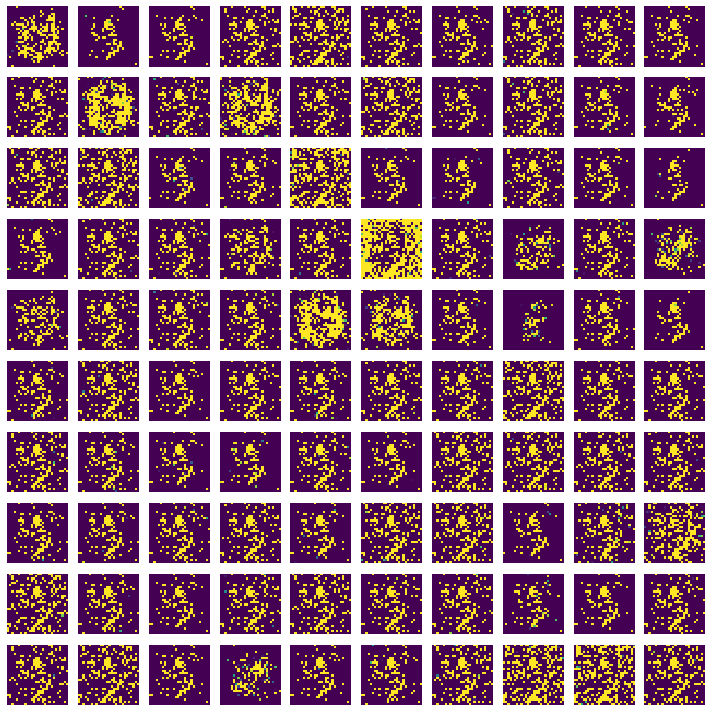

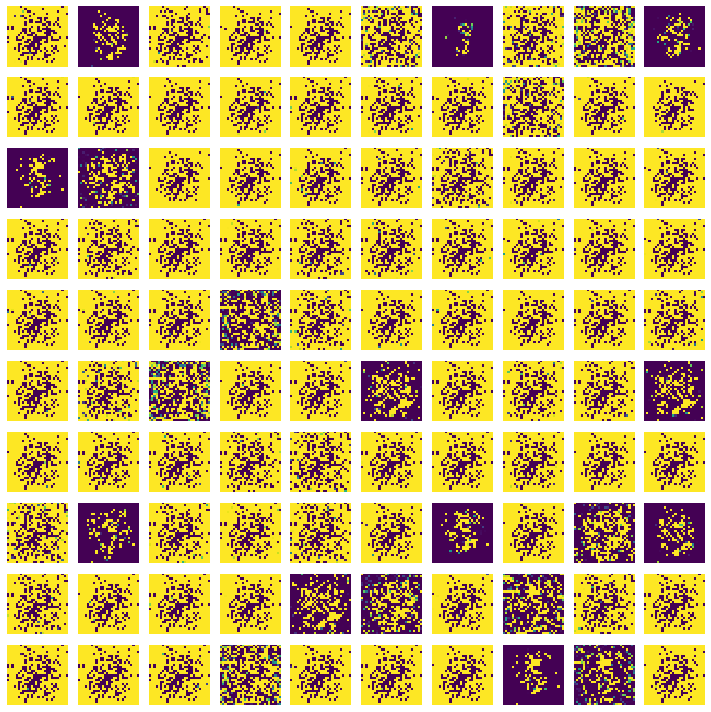

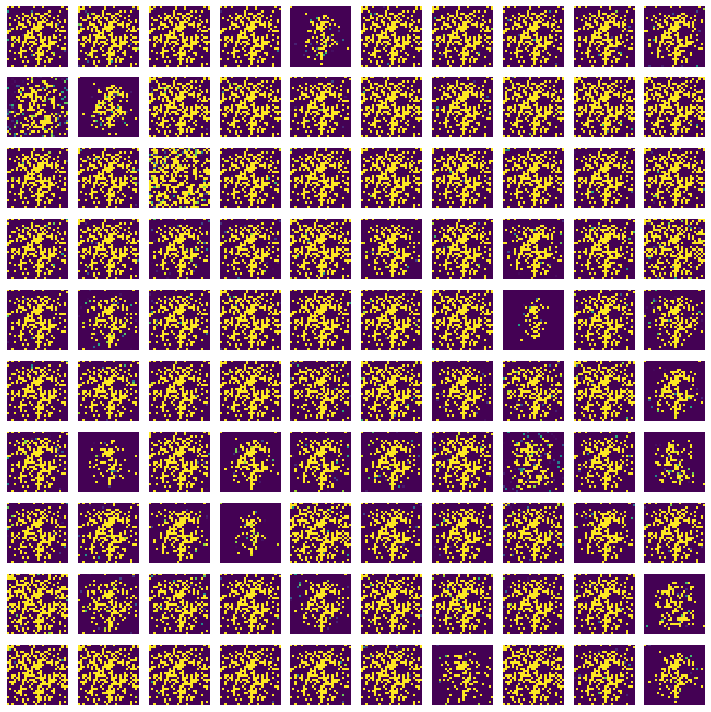

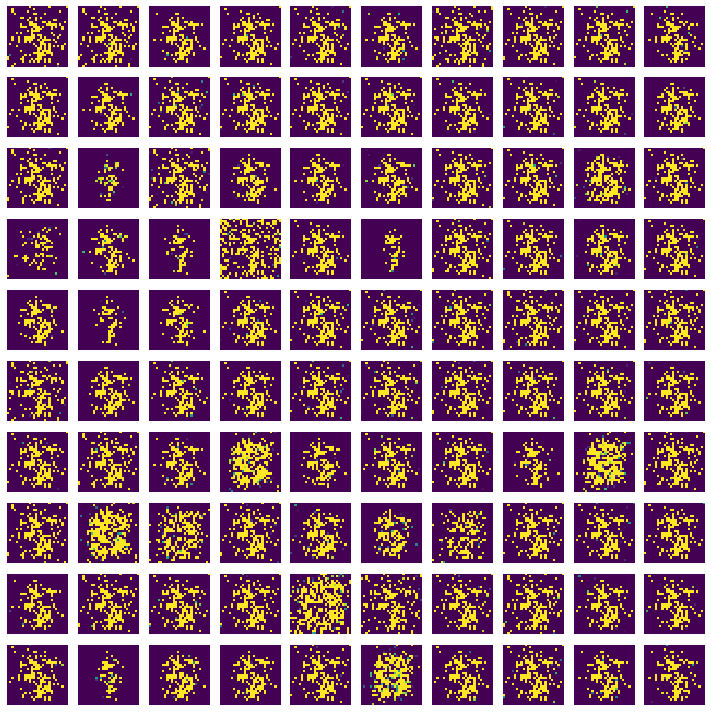

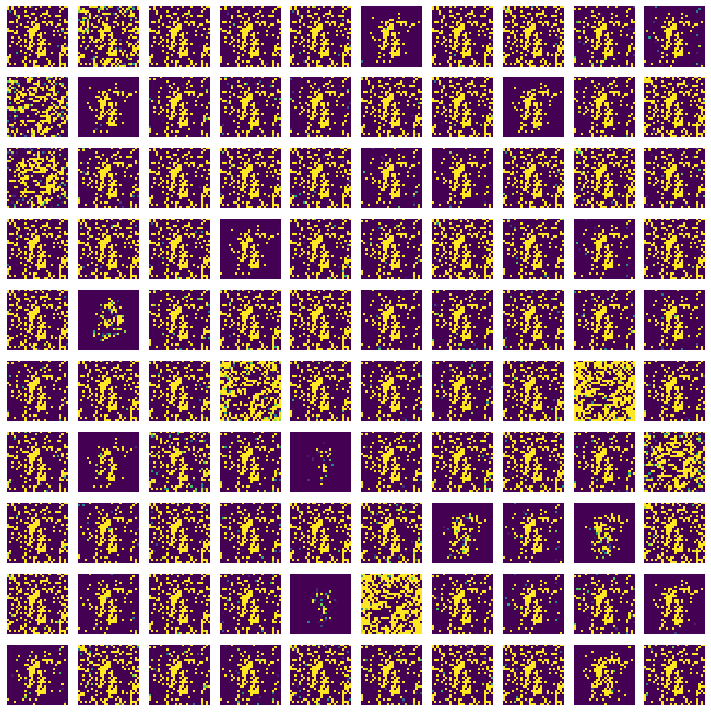

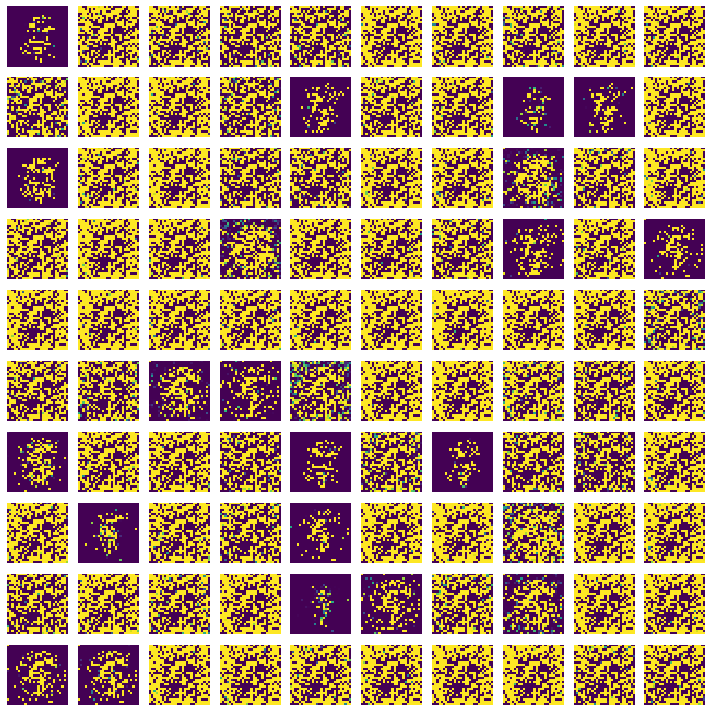

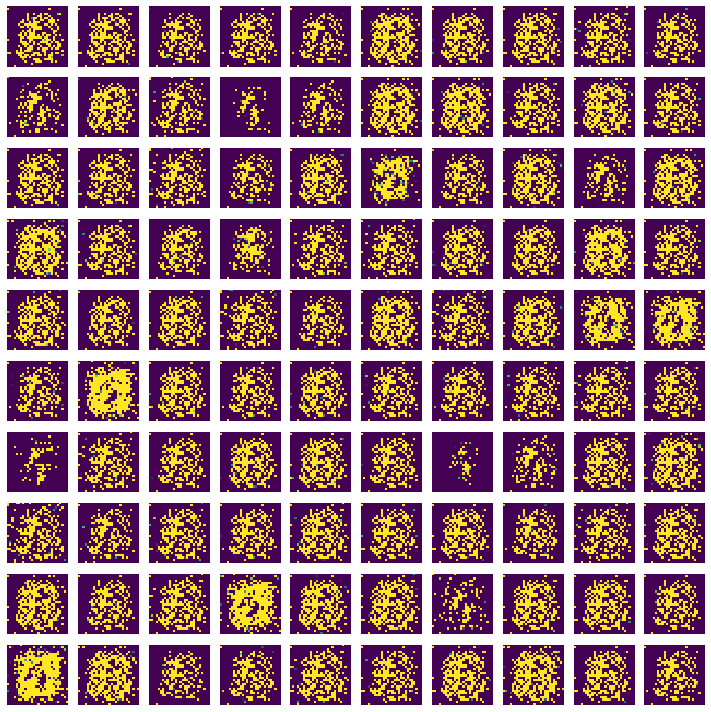

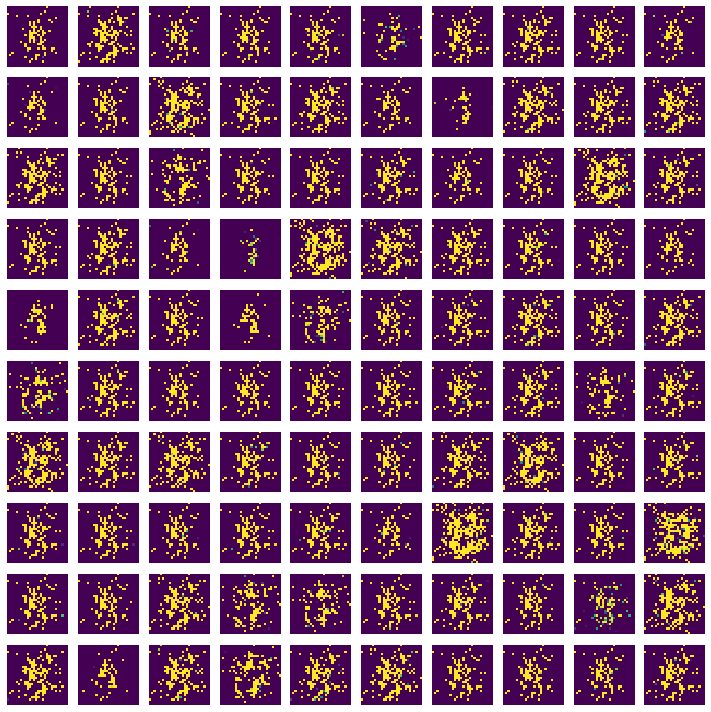

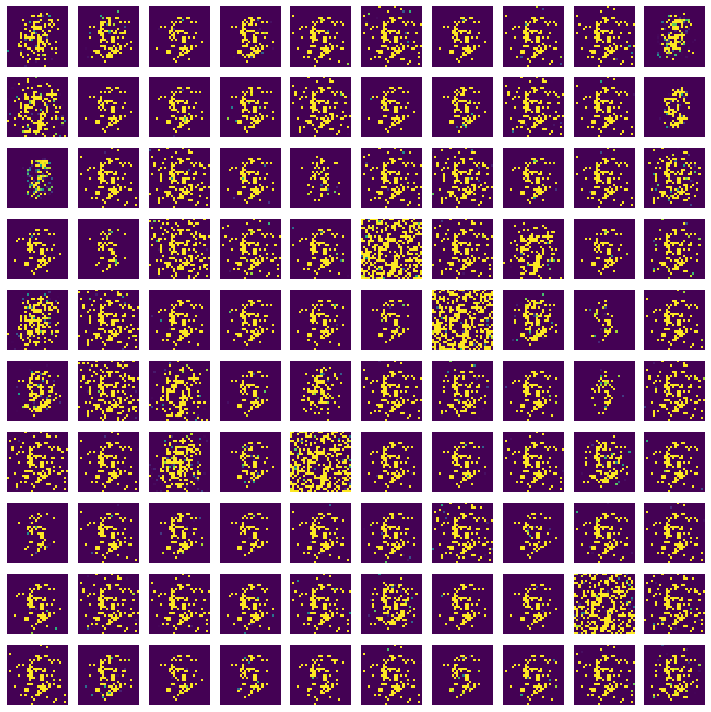

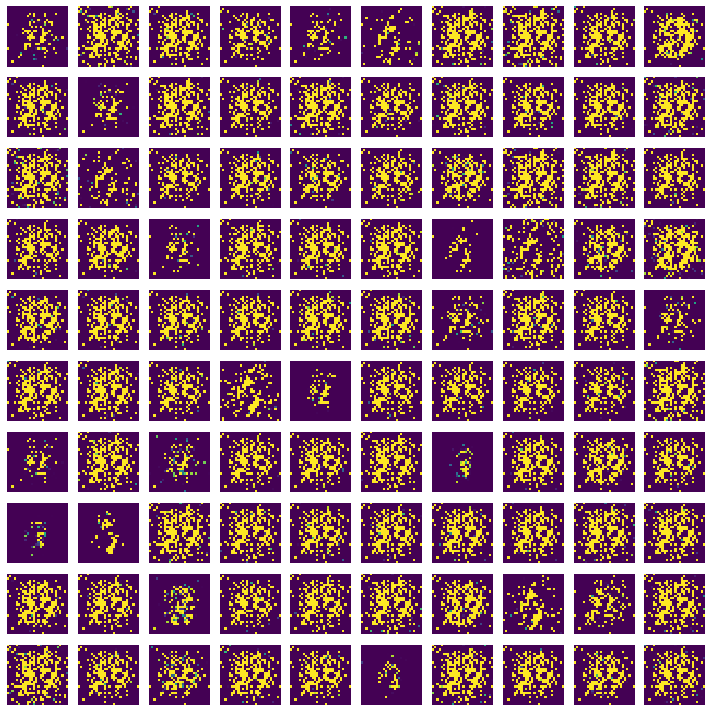

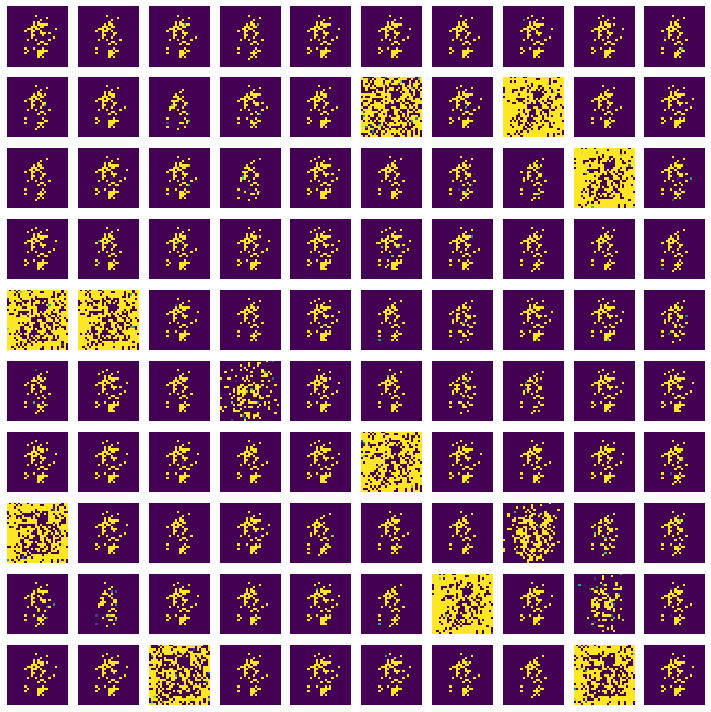

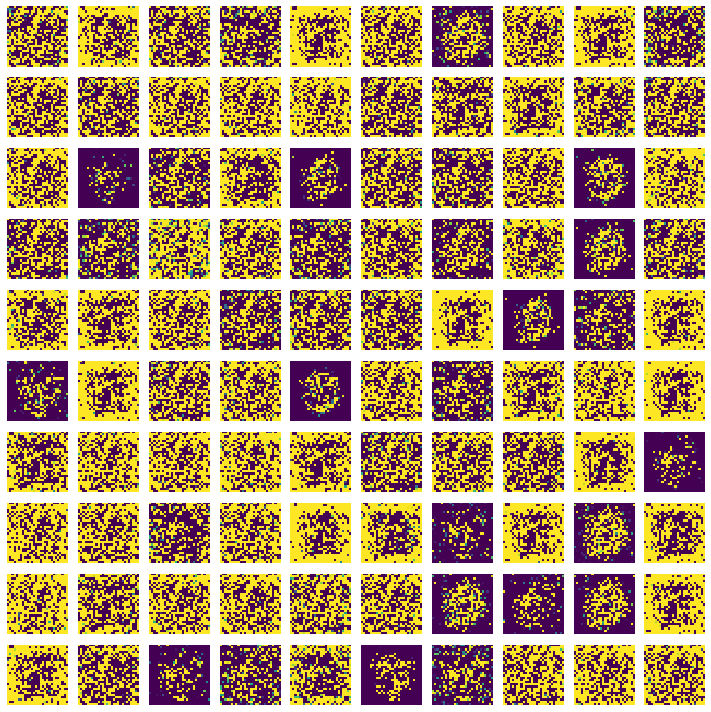

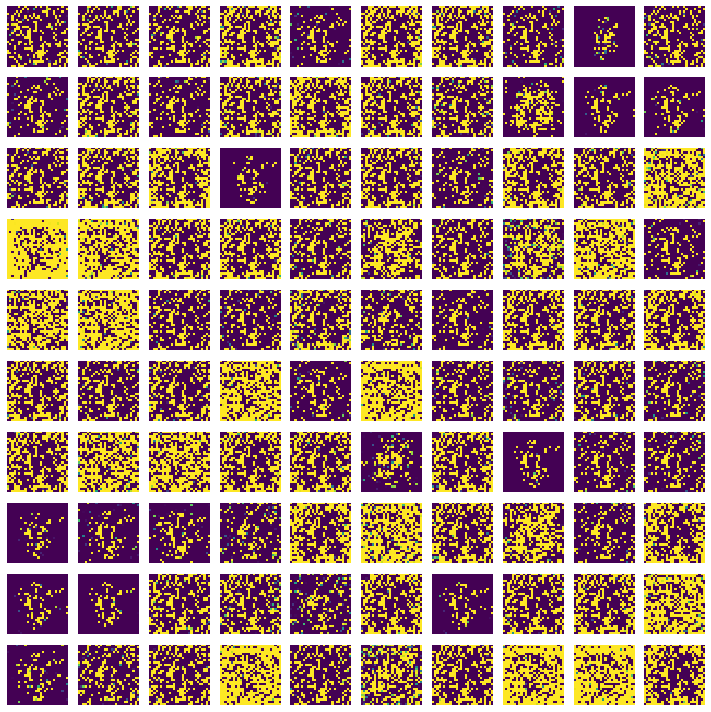

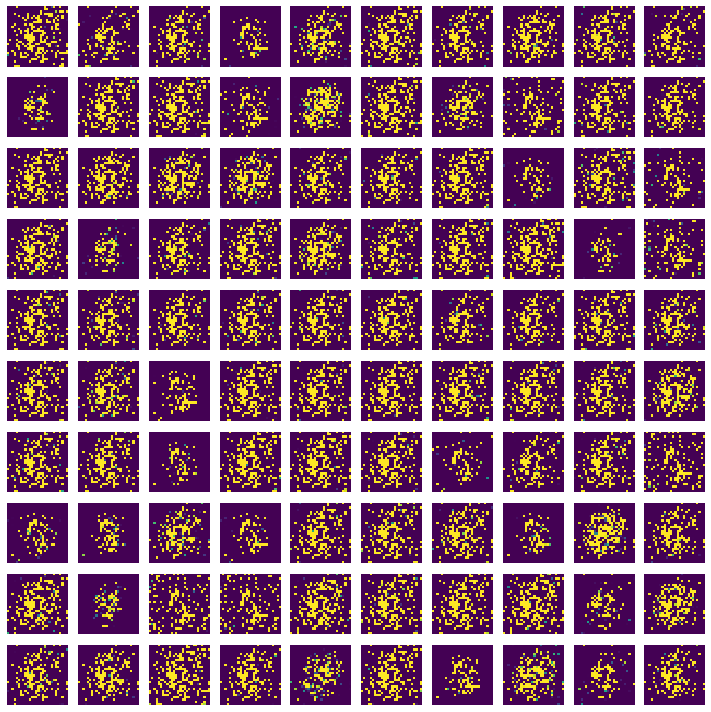

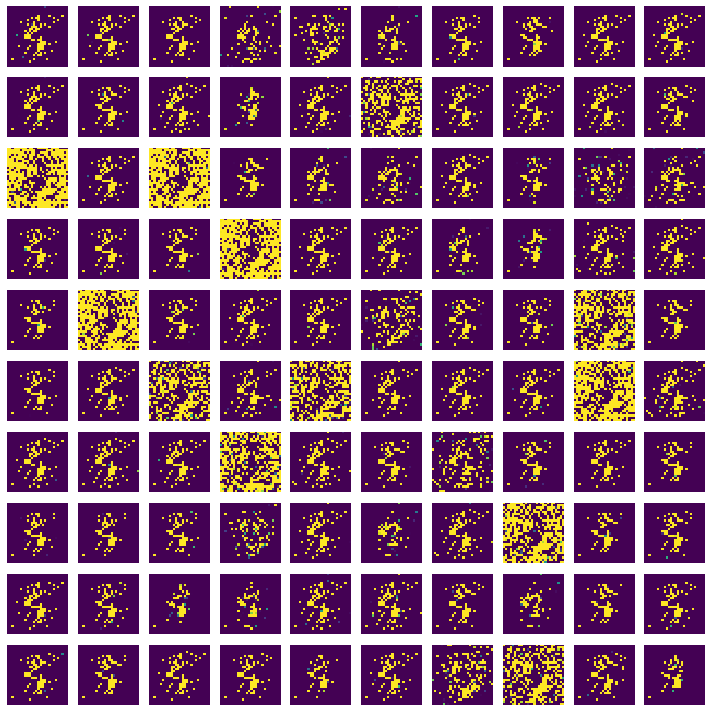

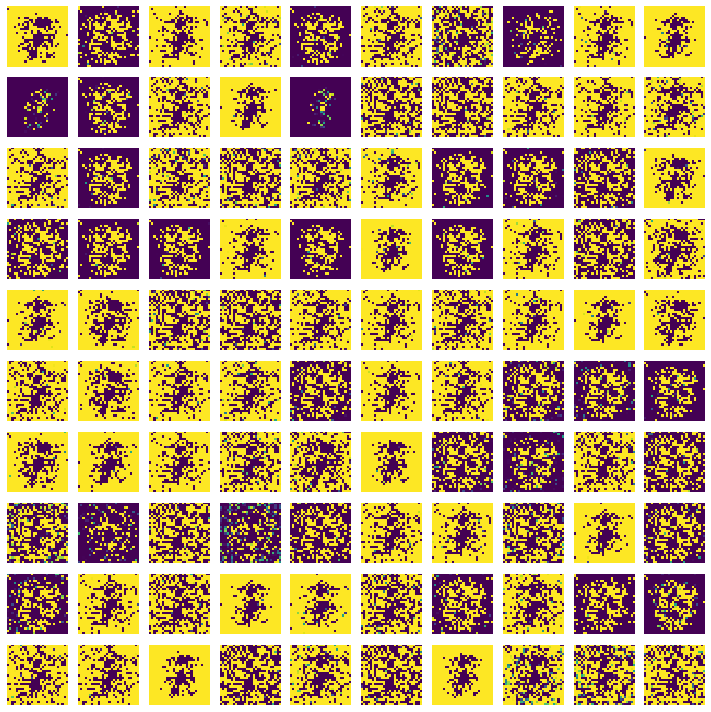

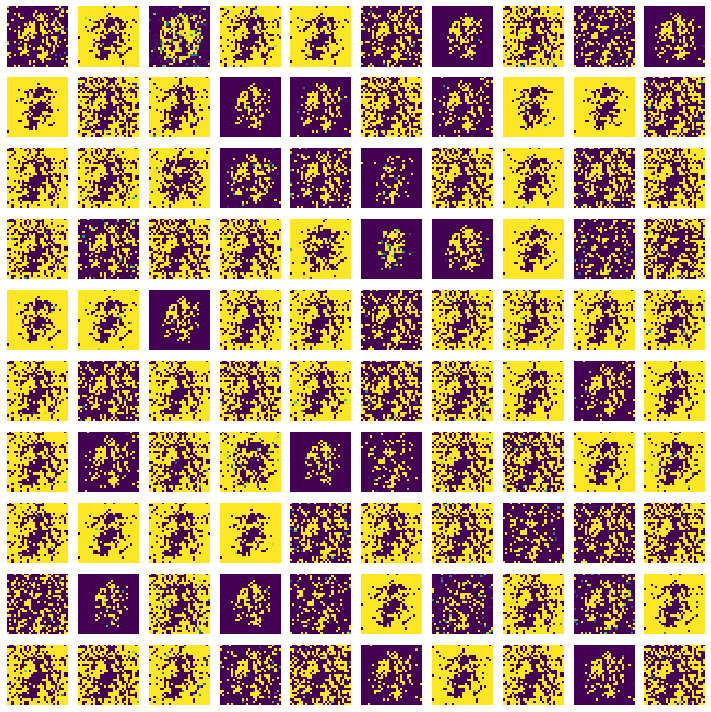

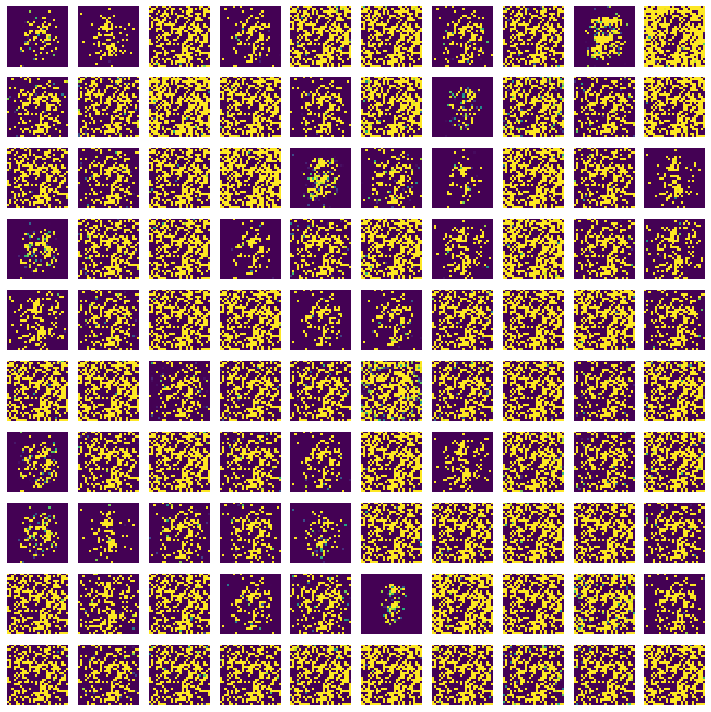

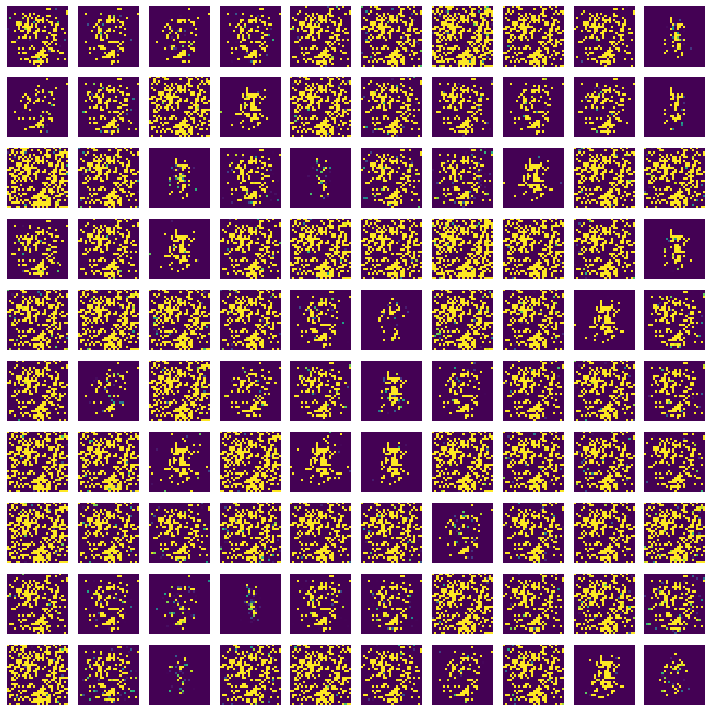

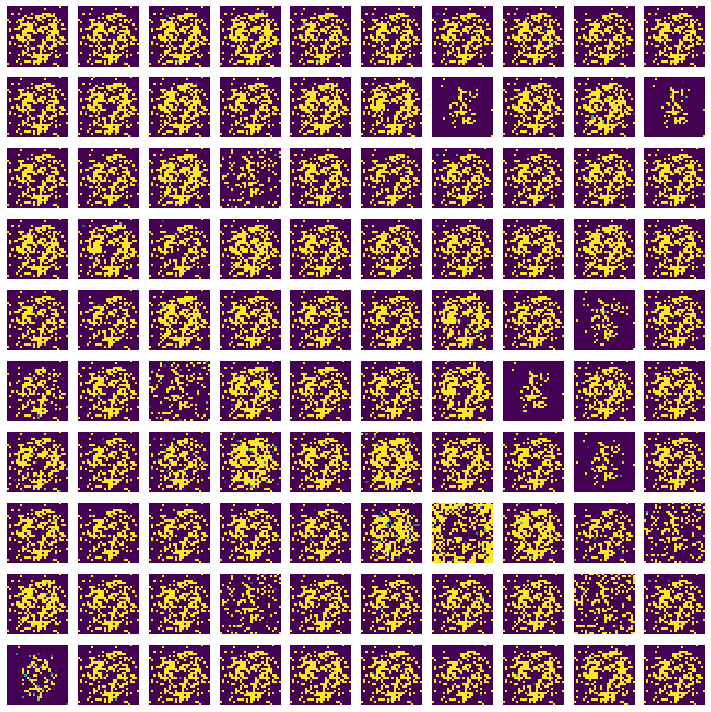

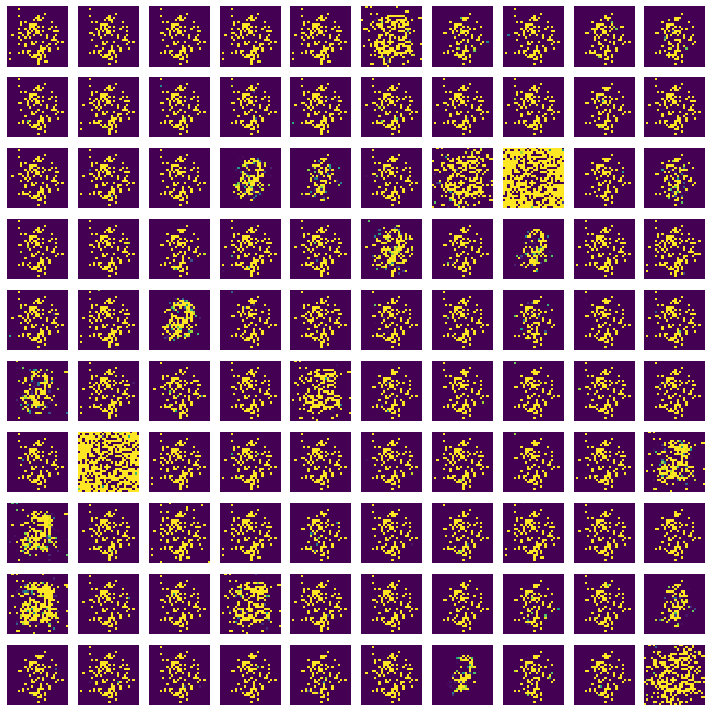

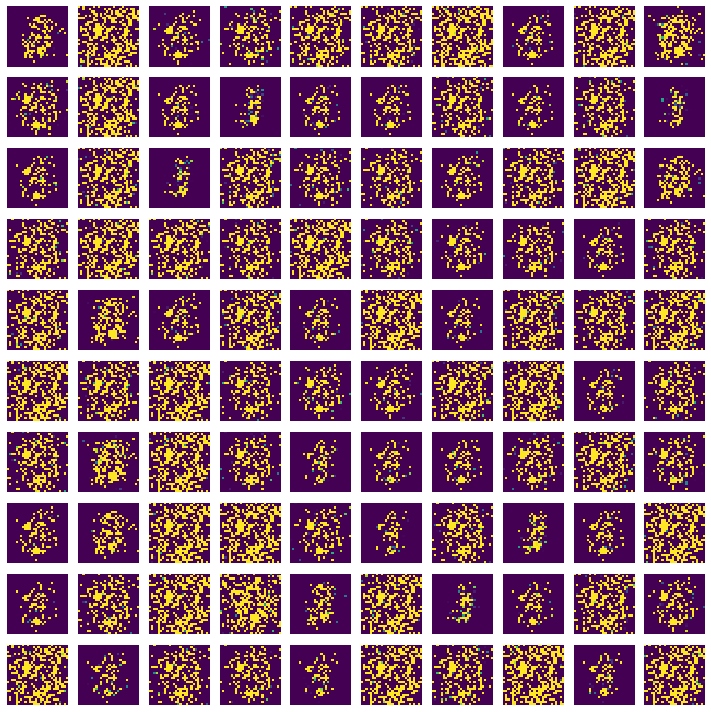

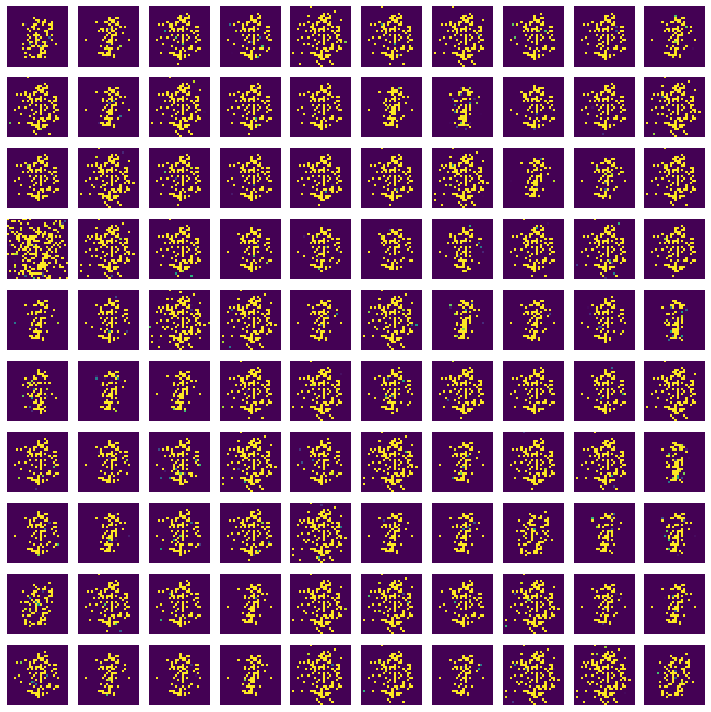

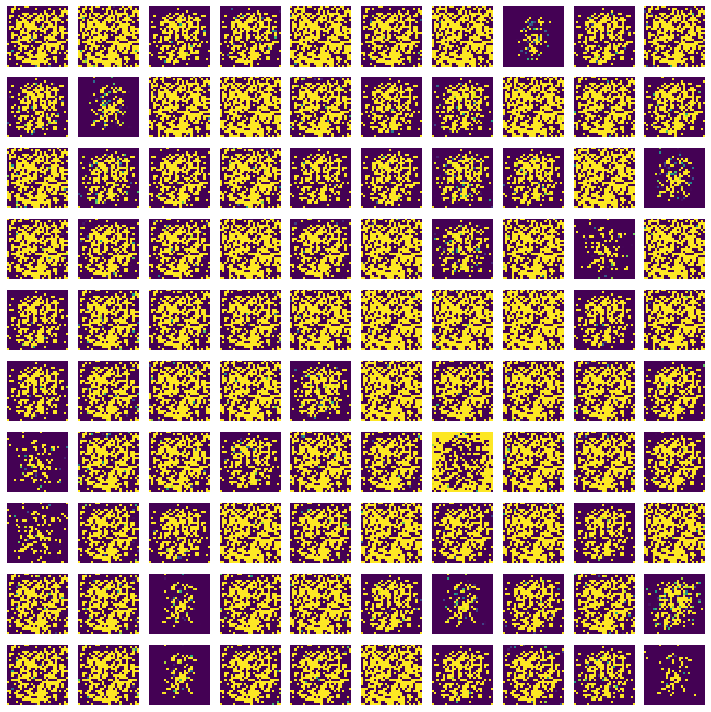

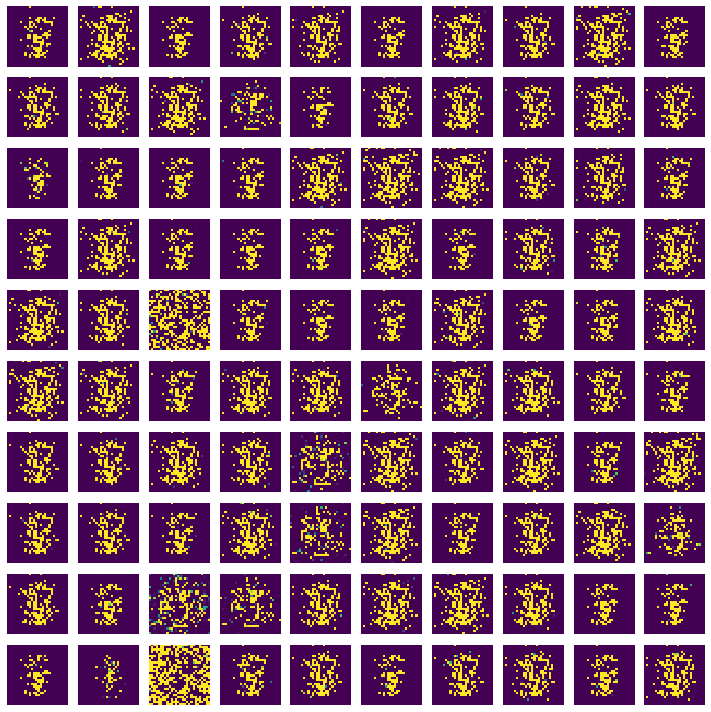

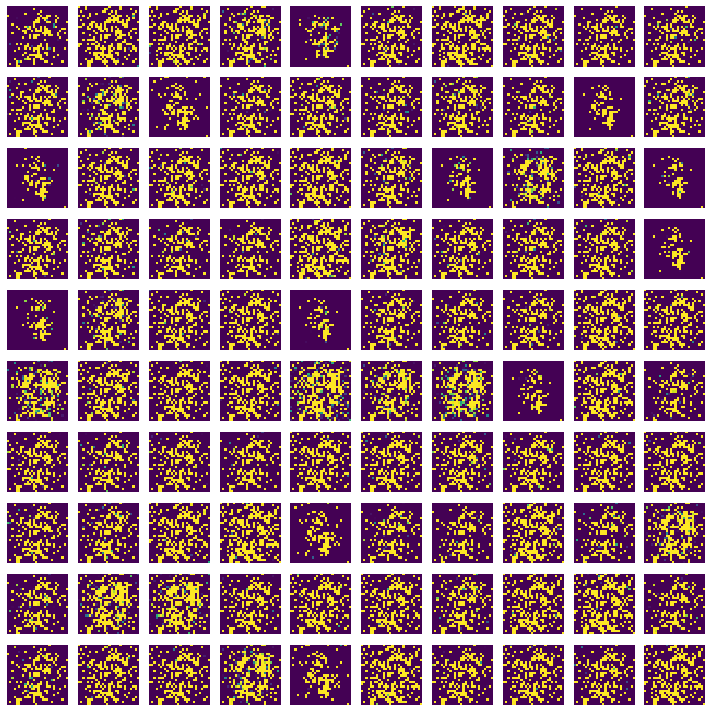

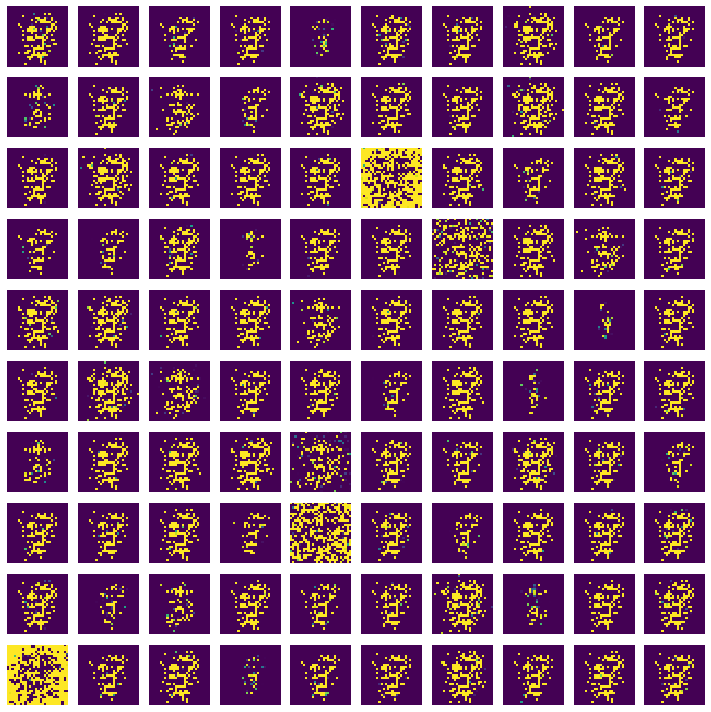

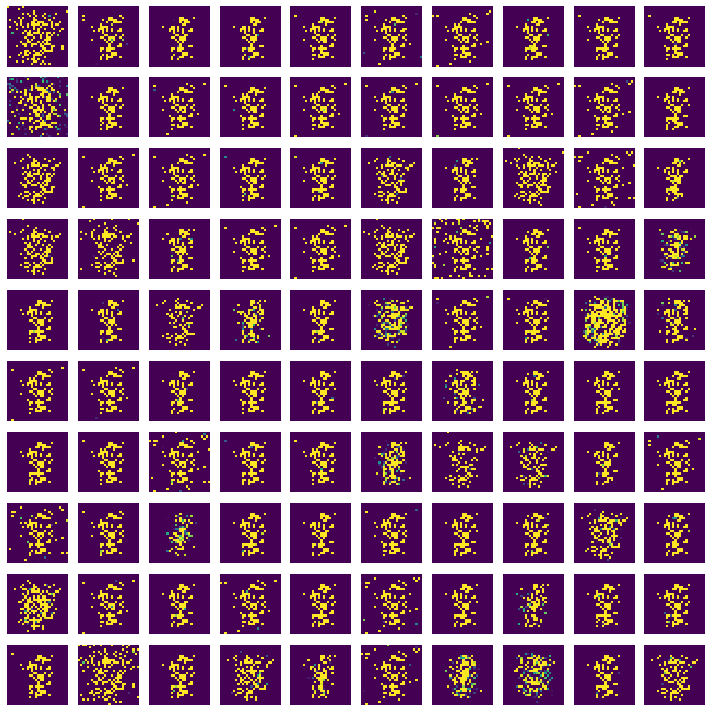

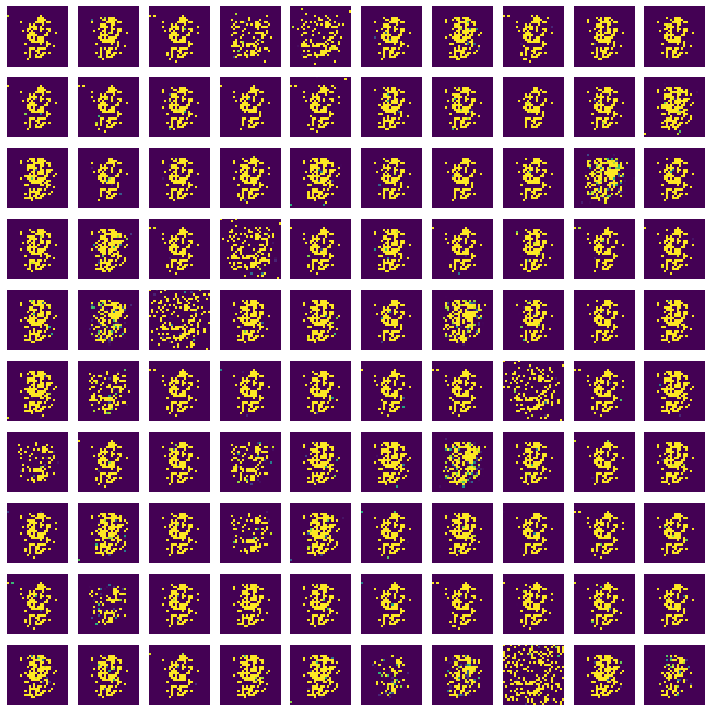

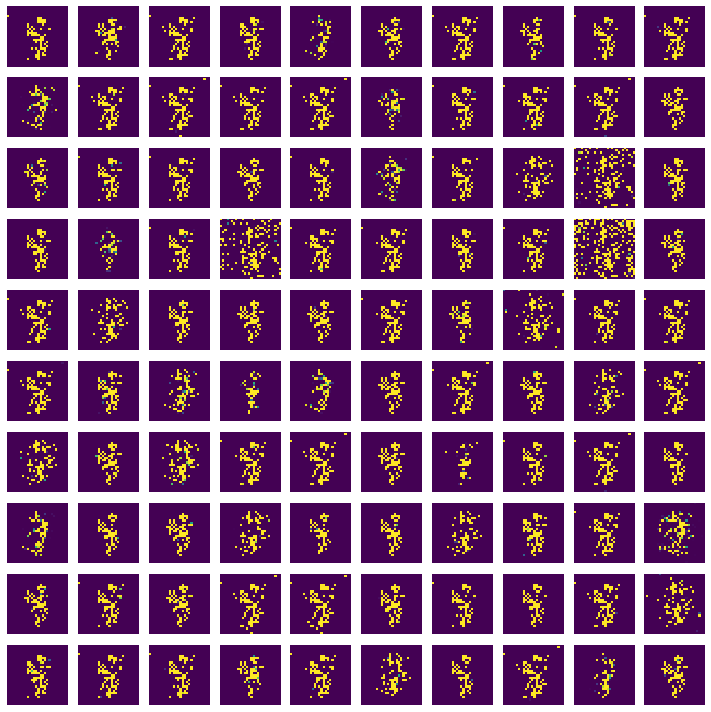

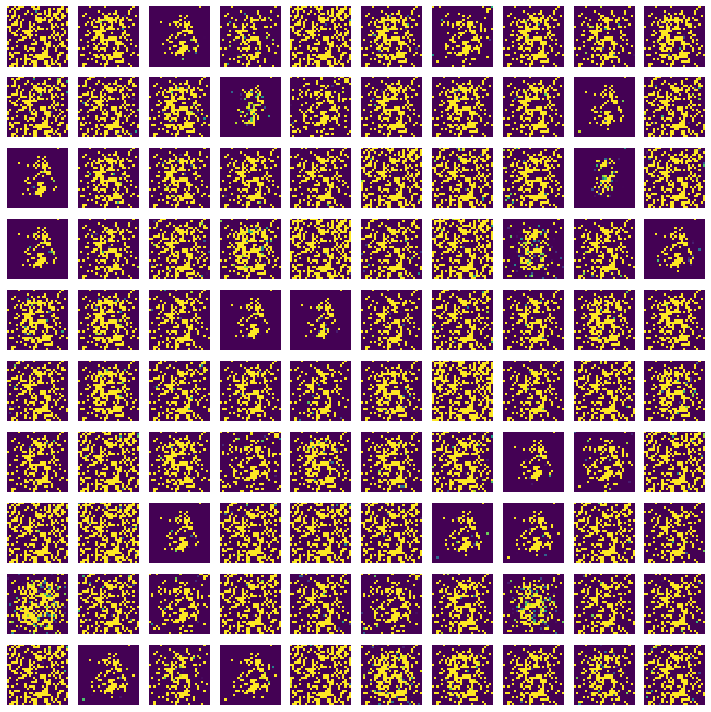

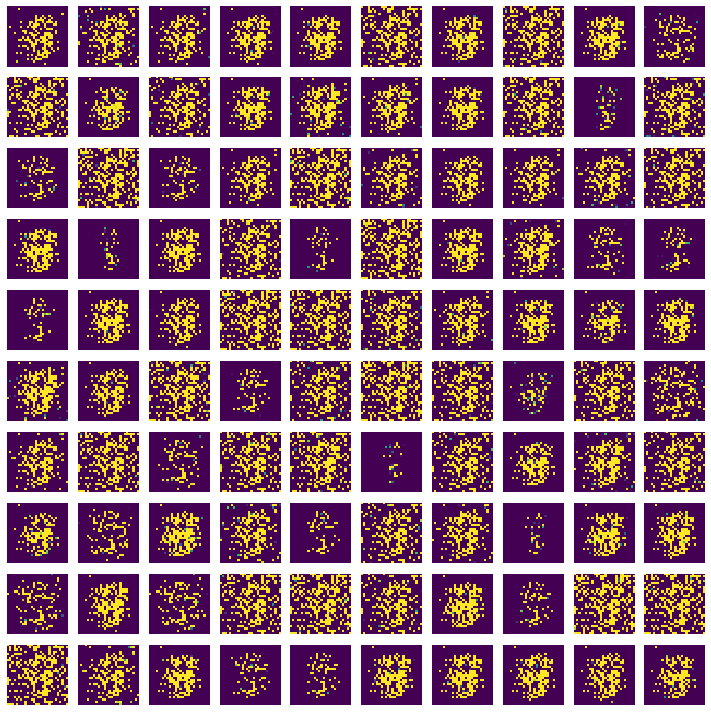

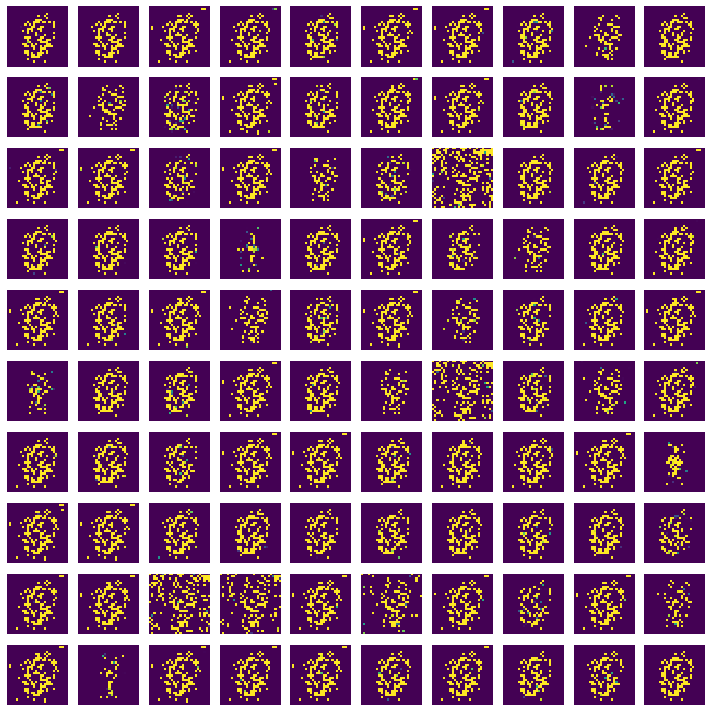

In [47]:
sample_period = 200

epochs = 30000

for epoch in range(epochs):

  ############################
  # TRAINING THE DISCRIMINATOR
  ############################

  # select random real images
  random_index = np.random.randint(0, len(X_train) - 1, batch_size)
  real_images = X_train[random_index]

  # select fake images
  noise = np.random.rand(batch_size, DIM)
  fake_images = generator.predict(noise)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_images, zeros)
  d_loss = (d_loss_real + d_loss_fake) / 2
  d_acc  = (d_acc_real + d_acc_fake) / 2

  ########################
  # TRAINING THE GENERATOR
  ########################

  noise = np.random.rand(batch_size, DIM)
  
  g_loss = gan.train_on_batch(noise, ones)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    plot_generated_images(epoch, generator)
    #sample_images(epoch)

In [0]:
# sample_period = 200
# latent_dim = 100
# # Store the losses
# d_losses = []
# g_losses = []

# # Main training loop
# for epoch in range(epochs):
#   ###########################
#   ### Train discriminator ###
#   ###########################
  
#   # Select a random batch of images
#   random_index = np.random.randint(0, len(X_train) - 1, batch_size)
#   real_images = X_train[random_index]
  
#   # Generate fake images
#   noise = np.random.randn(batch_size, latent_dim)
#   fake_imgs = generator.predict(noise)
  
#   # Train the discriminator
#   # both loss and accuracy are returned
#   d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
#   d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
#   d_loss = 0.5 * (d_loss_real + d_loss_fake)
#   d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
#   #######################
#   ### Train generator ###
#   #######################
  
#   noise = np.random.randn(batch_size, latent_dim)
#   g_loss = gan.train_on_batch(noise, ones)
  
#   # # do it again!
#   # noise = np.random.randn(batch_size, latent_dim)
#   # g_loss = gan.train_on_batch(noise, ones)
  
#   # Save the losses
#   d_losses.append(d_loss)
#   g_losses.append(g_loss)
  
#   if epoch % 100 == 0:
#     print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
  #     d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  # # if epoch % sample_period == 0:
  # #   sample_images(epoch)